In [86]:
import warnings
from datetime import date

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import pymc as pm
import arviz as az

from dataset import load_from_csv, remove_payment_duplicates, remove_user_group_duplicates


sns.set_style(rc={"figure.figsize": (8, 3)})
warnings.filterwarnings("ignore")

In [91]:
import logging

logger = logging.getLogger("pymc")
logger.setLevel(logging.ERROR)

### Loading & Cleaning Dataset

In [2]:
ab_df = load_from_csv()

In [3]:
ab_df = remove_payment_duplicates(ab_df)

No. of duplicates:  90
No. of payments:    0


In [4]:
ab_df = remove_user_group_duplicates(ab_df)

No. of users duplicated across groups:   3


In [5]:
print("Rows count:         {}".format(ab_df.shape[0]))
print("Users count:        {}".format(ab_df["user_id"].nunique()))

Rows count:         83241
Users count:        72850


### AB-test monitoring simulation

In [23]:
ab_start_date = ab_df["install_time"].dt.date.min() + pd.Timedelta(days=1)
ab_end_date = ab_df["payment_time"].dt.date.dropna().max() + pd.Timedelta(days=1)

In [47]:
def observe_data(
        df: pd.DataFrame,
        observation_date: str | date
) -> pd.DataFrame:
    obs_df = df.query(f"install_time < '{observation_date}'")
    obs_df["conversion"] = obs_df["payment_time"] < pd.to_datetime(observation_date)
    obs_df = (
        obs_df
        .groupby(["user_id", "ab_group"], as_index=False)
        .agg(
            conversion=("conversion", "max")
        )
    )
    obs_df["observation_date"] = pd.to_datetime(observation_date)

    return obs_df

In [50]:
dates_list = pd.date_range(ab_start_date, ab_end_date)

In [57]:
daily_obs_df = list()

for obs_date in tqdm(dates_list):
    df_ = observe_data(ab_df, obs_date)
    df_ = (
        df_
        .groupby(["observation_date", "ab_group"], as_index=False)
        .agg(
            users_count=("user_id", "count"),
            conversions_count=("conversion", "sum")
        )
    )
    daily_obs_df.append(df_)

daily_obs_df = pd.concat(daily_obs_df)

100%|██████████| 91/91 [00:02<00:00, 38.54it/s]


In [59]:
daily_obs_df["cr"] = daily_obs_df["conversions_count"] / daily_obs_df["users_count"]

In [92]:
def perform_bayes(
        obs_df: pd.DataFrame
):
    successes_1, trials_1 = obs_df.query("ab_group == 1")["conversions_count"].iloc[0], obs_df.query("ab_group == 1")["users_count"].iloc[0]
    successes_2, trials_2 = obs_df.query("ab_group == 2")["conversions_count"].iloc[0], obs_df.query("ab_group == 2")["users_count"].iloc[0]

    with pm.Model() as model:
        # неинформативный приор - beta(1, 1)
        p1 = pm.Beta("p1", alpha=1, beta=1)
        p2 = pm.Beta("p2", alpha=1, beta=1)

        # моделируем наши конверсии с помощью биномиального распределения
        conv1 = pm.Binomial("conv1", n=trials_1, p=p1, observed=successes_1)
        conv2 = pm.Binomial("conv2", n=trials_2, p=p2, observed=successes_2)

        # в delta записываем распределение разницы переменных
        delta = pm.Deterministic("delta", p2 - p1)

        # сэмплируем апостериорные распределения
        trace = pm.sample(2000, return_inferencedata=True, progressbar=False)

    return trace

In [94]:
daily_bayes_df = list()

for obs_date in tqdm(dates_list):
    obs_trace = perform_bayes(daily_obs_df.query(f"observation_date == '{obs_date}'"))

    hdi_lower, hdi_upper = az.hdi(obs_trace, hdi_prob=0.95)["delta"].values
    significance = hdi_lower > 0 or hdi_upper < 0

    delta_samples = obs_trace.posterior["delta"].values.flatten()
    prob_greater = (delta_samples > 0).mean()
    prob_smaller = (delta_samples < 0).mean()

    daily_bayes_df.append({
        "observation_date": obs_date,
        "trace_obj": obs_trace,
        "hdi_lower": hdi_lower,
        "hdi_upper": hdi_upper,
        "significance": significance,
        "prob_greater": prob_greater,
        "prob_smaller": prob_smaller
    })

daily_bayes_df = pd.DataFrame(daily_bayes_df)

100%|██████████| 91/91 [10:17<00:00,  6.79s/it]


Здесь показана конверсия по группам с течением времени.

**Важный момент!** Я не указал какого-либо окна для расчета конверсии, поэтому она может быть смещена некоторое время

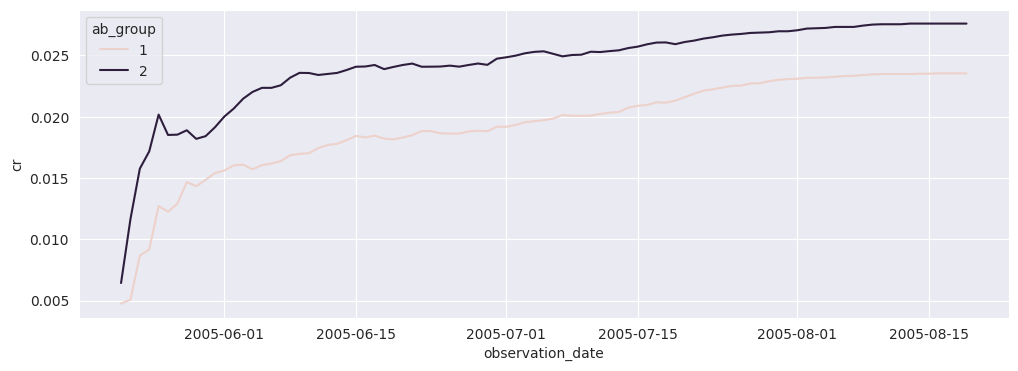

In [102]:
plt.figure(figsize=(12, 4))
sns.lineplot(
    x="observation_date",
    y="cr",
    hue="ab_group",
    data=daily_obs_df
)
plt.show()

Дальше показаны границы 95% HDI. Нижняя граница выше 0, а значит делаем вывод о статистической значимости

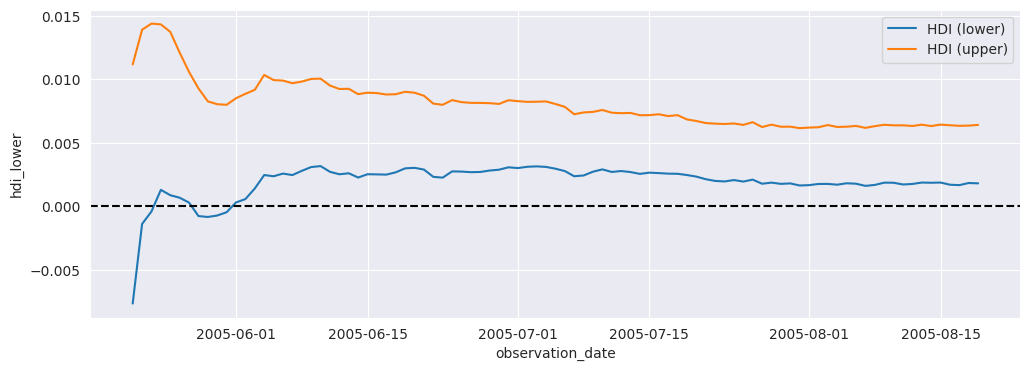

In [98]:
plt.figure(figsize=(12, 4))
sns.lineplot(
    x="observation_date",
    y="hdi_lower",
    label="HDI (lower)",
    data=daily_bayes_df
)
sns.lineplot(
    x="observation_date",
    y="hdi_upper",
    label="HDI (upper)",
    data=daily_bayes_df
)
plt.legend()
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

Далее показаны вероятности того, что статистика одной группы выше, чем у другой. p(B>A) > 95% можем также использовать как порог для принятия решения

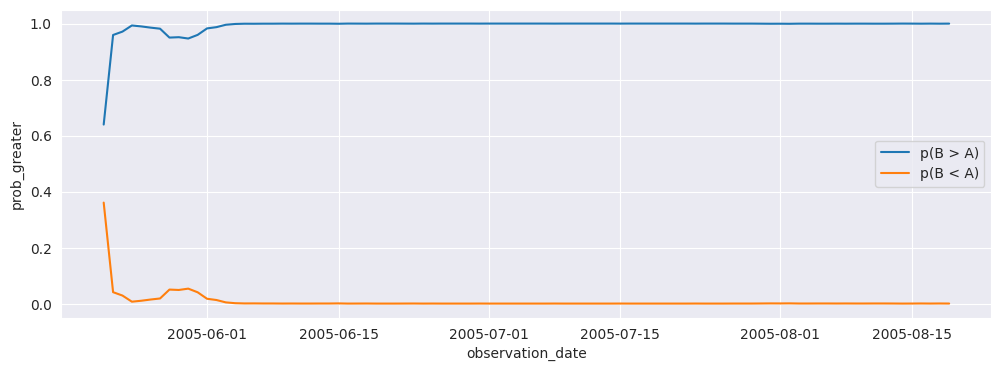

In [101]:
plt.figure(figsize=(12, 4))
sns.lineplot(
    x="observation_date",
    y="prob_greater",
    label="p(B > A)",
    data=daily_bayes_df
)
sns.lineplot(
    x="observation_date",
    y="prob_smaller",
    label="p(B < A)",
    data=daily_bayes_df
)
plt.legend()
plt.show()

Далее показаны апостериорные распределения конверсий, а также разница между ними

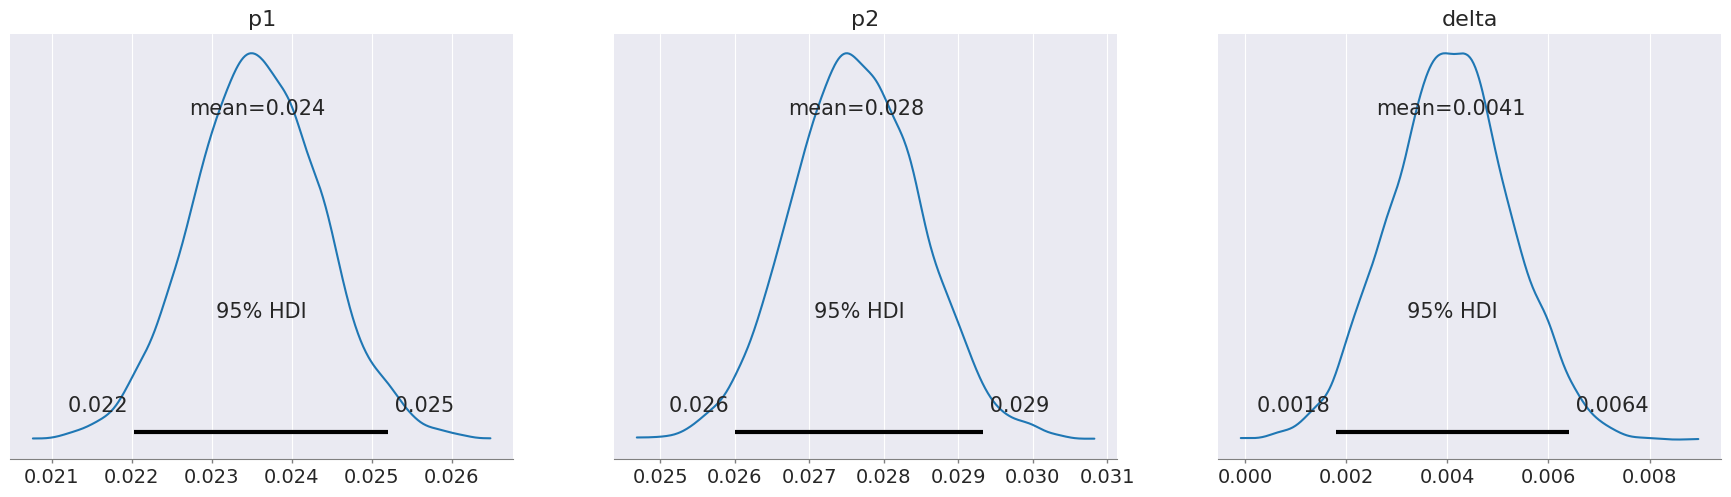

In [99]:
az.plot_posterior(
    daily_bayes_df.query(f"observation_date == '{ab_end_date}'")["trace_obj"].iloc[0],
    var_names=["p1", "p2", "delta"],
    hdi_prob=0.95
)
plt.show()